In [1]:
def train_test_split(X, y, test_p=0.25, random_state=42):
    ids = np.unique(X.index.values)
    test_size = math.floor(test_p * len(ids))
    test_index = np.random.choice(ids, size=test_size)
    X_train = X[~X.index.isin(test_index)]
    X_test = X[X.index.isin(test_index)]
    y_train = y[~y.index.isin(test_index)]
    y_test = y[y.index.isin(test_index)]
    return X_train, X_test, y_train, y_test

In [66]:
def feature_selection(X_train, y_train, model, variance_threshold=0, step=0.05, num_features=100, verbose=0, n_jobs=10):
    n = len(y_train)
    vals, counts = np.unique(y_train, return_counts=True)
    k = min(counts)
    k = 5
    # Apply variance threshold on features
    # TODO: note that this is probably removing dummy variables with low variance; only matters in multi-drug case
    variance_selector = VarianceThreshold(threshold=variance_threshold)
    variance_selector.fit(X_train)
    var_selected_features = X_train.columns[variance_selector.get_support()]
    X_train_selected = X_train.loc[:, var_selected_features]

    # Recursive feature elimination with cross validation
    selector = RFECV(model, min_features_to_select=num_features, step=step, verbose=verbose, n_jobs=n_jobs, cv=k)
    # TODO: figure out way to output scores of intermediate selectors
    selector.fit(X_train_selected, y_train)
    selected_features = X_train_selected.columns[selector.get_support()]
    return selector, selected_features, var_selected_features

In [3]:
def test_model(X_test, y_test, model):
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return y_pred, score

## Imports and data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
discretize = 1

In [5]:
# expression_df = pd.read_csv('../data/processed/expression_tpm_log.tsv', sep='\t', index_col=0)
expression_df = pd.read_csv('../data/processed/expression_tpm_minmax.tsv', sep='\t', index_col=0)

In [6]:
expression_df = expression_df.set_index('pog_id')

In [7]:
drugs_df = pd.read_csv('../data/processed/drugs_prognosis.tsv', sep='\t', index_col=0)

In [44]:
drugs_selected_df = drugs_df[['pog_id', 'response', 'prognosis', 'drug_name', 'cancer_cohort']]

# # Prepare features and labels
# ## Join drugs and expression tables

drugs_expression_df = drugs_selected_df.join(expression_df, on='pog_id', how='inner')
drugs_expression_df = drugs_expression_df.set_index('pog_id')
# RESPONSE OR PROGNOSIS?
drugs_expression_df = drugs_expression_df.loc[:, np.append(['prognosis', 'drug_name', 'cancer_cohort'], expression_df.columns.values)]
drugs_expression_df = drugs_expression_df.drop_duplicates()

# cancer_types = np.append(np.unique(drugs_expression_df['cancer_cohort']), 'All')
# drug_names = np.append(np.unique(drugs_expression_df['drug_name']), 'All')

X_master = drugs_expression_df.loc[:, expression_df.columns.values]
# X_master = pd.get_dummies(X_master, columns=['drug_name'])
y_master = drugs_expression_df.loc[:, 'prognosis']

## Examine COLOREAD patients for prognosis difference using transcriptome?

In [45]:
COLO_mask = drugs_expression_df['cancer_cohort'] == 'COLO'

In [437]:
# X = X_master[(drugs_expression_df['cancer_cohort'] == 'BRCA') & (drugs_expression_df['drug_name'] == 'ERIBULIN')]
# y = y_master[(drugs_expression_df['cancer_cohort'] == 'BRCA') & (drugs_expression_df['drug_name'] == 'ERIBULIN')]
# X = X_master[drugs_expression_df['drug_name'] == 'GEMCITABINE']
# y = y_master[drugs_expression_df['drug_name'] == 'GEMCITABINE']

In [46]:
X = X_master[COLO_mask]
y = y_master[COLO_mask]

In [48]:
X = X.drop_duplicates()

## sci-kit

In [49]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [50]:
from sklearn.preprocessing import PowerTransformer

In [51]:
from sklearn.feature_selection import RFECV, VarianceThreshold

In [52]:
from sklearn.model_selection import KFold

## transform response?

In [67]:
# Power transform y
# power_transformer = PowerTransformer(method='box-cox', standardize=True)
# y_trans = power_transformer.fit_transform(y.values.reshape(-1, 1))[:, 0]
# y_trans = pd.Series(index=y.index, data=y_trans)

## Custom train test split on POG ids

In [53]:
discretize = False

In [54]:
X_train = []
y_train = []
X_test = []
y_test = []
n_iter = 10
while ((len(np.unique(y_test)) < 2) or (len(np.unique(y_train)) < 2) or (n_iter > 1)):
    n_iter -= 1
    # Determine test set mask
    if discretize:
        X_train, X_test, y_train, y_test = train_test_split(X, y_trans)
        # Discretize y if binary classification problem
        # TODO: In case not binary classification, implement a better discretization
        y_train = y_train > 0
        y_test = y_test > 0
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y)

In [55]:
# TODO: This is a new feature. Need to add to script
X_train.reset_index(level=0, inplace=True)
X_train = X_train.drop_duplicates(subset=['pog_id'], keep='first')
X_train.set_index('pog_id', inplace=True)
# TODO: This is a new feature. Need to add to script
X_test.reset_index(level=0, inplace=True)
X_test = X_test.drop_duplicates(subset=['pog_id'], keep='first')
X_test.set_index('pog_id', inplace=True)

In [56]:
# TODO: This is a new feature. Need to add to script
y_train_df = pd.DataFrame(y_train)
y_train_df.reset_index(level=0, inplace=True)
y_train_df = y_train_df.drop_duplicates(subset=['pog_id'], keep='first')
y_train = y_train_df.set_index('pog_id')


In [57]:
# TODO: This is a new feature. Need to add to script
y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(level=0, inplace=True)
y_test_df = y_test_df.drop_duplicates(subset=['pog_id'], keep='first')
y_test = y_test_df.set_index('pog_id')


## test if X_train and X_test have overlapping indices

In [58]:
np.intersect1d(X_train.index, X_test.index)

array([], dtype=object)

In [59]:
np.intersect1d(y_train.index, y_test.index)

array([], dtype=object)

## Random forest

In [64]:
kf = KFold(n_splits=len(X), random_state=None, shuffle=False)

In [69]:
# RANDOM FOREST
selector, selected_columns, var_selected_features = feature_selection(X_train, y_train, RandomForestRegressor(n_jobs=4, n_estimators=100, random_state=42), step=0.05, n_jobs=4, num_features=10, variance_threshold=0)




/Users/emreerhan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


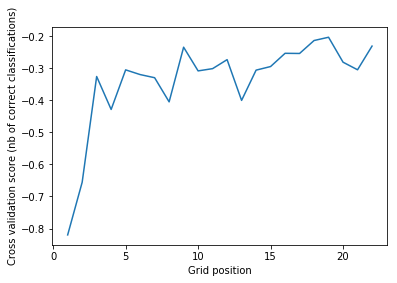

In [70]:
plt.figure()
plt.xlabel("Grid position")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [71]:
X_test_selected = X_test.loc[:, var_selected_features]
X_train_selected = X_train.loc[:, var_selected_features]

In [72]:
# training score
y_train_pred, score = test_model(X_train_selected, y_train, selector)

In [73]:
score

0.8474129351837589

In [74]:
y_pred, score = test_model(X_test_selected, y_test, selector)

In [75]:
score

0.17797239761092154

In [76]:
selected_columns

Index(['ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461',
       'ENSG00000001497',
       ...
       'ENSG00000283667', 'ENSG00000283669', 'ENSG00000283674',
       'ENSG00000283679', 'ENSG00000283683', 'ENSG00000283684',
       'ENSG00000283689', 'ENSG00000283696', 'ENSG00000283697',
       'ENSG00000283698'],
      dtype='object', length=37690)

In [77]:
rf_features = selected_columns

## Linear SVM

In [78]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [81]:
# SVM
selector, selected_columns, var_selected_features = feature_selection(X_train, y_train, SVR(C=0.1, max_iter=10000, random_state=42), step=0.05, n_jobs=32, num_features=10, variance_threshold=0)

NameError: name 'SVR' is not defined

In [ ]:
plt.figure()
plt.xlabel("Grid position")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [502]:
scores = []
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    selector.estimator.fit(X.iloc[train_index, :][selected_columns], y[train_index])
    scores.append(selector.estimator.score(X.iloc[test_index, :][selected_columns], y[test_index]))

/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblin

In [511]:
scores

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [496]:
selected_columns

Index(['ENSG00000000419', 'ENSG00000001167', 'ENSG00000001460',
       'ENSG00000001461', 'ENSG00000001497', 'ENSG00000001617',
       'ENSG00000001626', 'ENSG00000001630', 'ENSG00000001631',
       'ENSG00000002079',
       ...
       'ENSG00000283472', 'ENSG00000283485', 'ENSG00000283526',
       'ENSG00000283553', 'ENSG00000283554', 'ENSG00000283585',
       'ENSG00000283623', 'ENSG00000283633', 'ENSG00000283644',
       'ENSG00000283646'],
      dtype='object', length=12310)

In [466]:
svm_features = selected_columns

In [467]:
X_test_selected = X_test.loc[:, var_selected_features]
X_train_selected = X_train.loc[:, var_selected_features]

In [504]:
# training score
y_train_pred, score = test_model(X_train_selected, y_train, selector)

In [505]:
score

1.0

In [506]:
y_pred, score = test_model(X_test_selected, y_test, selector)

In [507]:
score

0.47619047619047616

## SVM RBF

In [472]:
# K fold cross validations

In [473]:
kf = KFold(n_splits=len(X), random_state=None, shuffle=False)

In [474]:
# Can't do RFE with SVM with RBF because it doesn't have feature importances
svm_rbf = SVC(kernel='rbf', C=1, max_iter=10000, random_state=42, gamma='scale')

In [476]:
svm_rbf.score(X_test.loc[:, rf_features], y_test)

0.0

In [477]:
X_test_selected = X_test.loc[:, var_selected_features]
X_train_selected = X_train.loc[:, var_selected_features]

In [478]:
# training score
y_train_pred, score = test_model(X_train_selected, y_train, selector)

In [479]:
score

1.0

In [480]:
y_pred, score = test_model(X_test_selected, y_test, selector)

In [481]:
score

0.47619047619047616

## feature importances

In [ ]:
selector.estimator.fit(X_train_selected, y_train)

In [210]:
selector.estimator.score(X_test_selected, y_test)

-0.14858053804973892